In [1]:
using Pkg

Pkg.activate("..")

using MiCRM_stability
using LinearAlgebra, KrylovKit
using StatsBase, Distances, Distributions
using CairoMakie, ColorSchemes
using DelimitedFiles
using Random
using Graphs, GraphMakie, NetworkLayout, SimpleWeightedGraphs
using LsqFit
using JLD2

  Activating project at `~/Projects/MiCRM_stability`


# Introduction

In this notebook I will look at the various factors determining stabiltiy in the generalised microbial model

In [5]:
function get_param_e_mean(p::MiCRM_stability.Parameters)
    fe = fieldnames(MiCRM_stability.exponential_params)
    ue = mean.(getfield.(Ref(p.e), fe))
    vcat(ue...) 
end

function get_param_s_mean(p::MiCRM_stability.Parameters)
    fs = fieldnames(MiCRM_stability.structural_params)
    us = mean.(getfield.(Ref(p.s), fs))
    vcat(us...) 
end


function get_real(x::T) where T <: AbstractFloat
    x
end

get_real(x::Complex) = x.re

Revise.revise()

In [6]:
#network structure functions
function get_A(com)
    N,M = com.N, com.M
    A = zeros(N+M, N+M)
    
    for i = 1:N
        for j = 1:M
            A[N + j, i] = com.U[i,j]
            A[i, N + j] = com.L[i,j]
        end
    end
    
    return(A)
end

function get_A_undir(com::MiCRM_stability.Community)
     N,M = com.N, com.M
    A = zeros(N+M, N+M)
    
    for i = 1:N
        for j = 1:M
            A[N + j, i] = com.U[i,j] + com.L[i,j]
            A[i, N + j] = com.L[i,j] + com.U[i,j]
        end
    end
    
    return(A)

end
    
function check_connected(com)
    A = get_A(com)
    g = SimpleWeightedDiGraph(A)
    return(is_connected(g))

    # return(sum(abs.(eigen(B).values) .< 1e-10) == 1 & all(sum(com.U,dims=2) .> 0))
end

check_connected (generic function with 1 method)

In [7]:
function rand_com(N,M,C, ci = rand(N), ca = rand(M))
    ci = ci[sortperm(sum.(ci))]    
    ca = ca[sortperm(sum.(ca))]
    d = ci .- ca'
    
    fu(x, dist) = dist > x >= 0 ? rand() : 0.0
    fl(x, dist) = -dist < x < 0 ? rand() : 0.0
    
    U = zeros(N,M)
    L = zeros(N,M)

    b = (1/C - 1)
    dβ = Beta(1, b)

    for i = 1:N
        ind = findmin(abs.(d[i,:]))[2]
        x = d[i,:] #.- d[i,ind]
        U[i,:] .= fu.(x, rand(dβ))
        L[i,:] .= fl.(x, rand(dβ))
    end

    #end products    
    U[:,end] .= 0.0
    L[:,1] .= 0.0

    return(MiCRM_stability.Community(N,M,U,L))
end

function shuffle!(com::MiCRM_stability.Community)
    U,L = com.U, com.L
    N,M = com.N, com.M

    #U
    if rand() < 0.5
        ind = findall(com.U .!= 0)
        #sample links
        f = rand(ind)
        #dont assign upatke to last node
        t = rand(CartesianIndices((1:N, 1:(M-1))))

        tmp = U[f]
        U[f] = U[t]
        U[t] = tmp
    else
        ind = findall(com.L .!= 0)
        #sample links
        f = rand(ind)
        #dont assign upatke to last node
        t = rand(CartesianIndices((1:N, 2:M)))

        tmp = L[f]
        L[f] = L[t]
        L[t] = tmp
    end
        
   
end

shuffle! (generic function with 1 method)

In [8]:
#get trophic levels
function get_TL(A)
    v = sum(A, dims = 2)[:]
    v[v .== 0] .= 1
    Λ = diagm(v) - A
    
    if rank(Λ) >= length(A[1,:])
        s = inv(Λ) * v
        return s
    else
        return 0
    end
end

function get_TC(A)
    s = get_TL(A)

    if s != 0  
        S = length(s)
        x = [s[i] - s[j] for i = 1:S, j = 1:S]
        return std(x[x .!= 0])
    else
        return 0
    end
end

get_TC (generic function with 1 method)

In [9]:
Random.seed!(1)

#test 
N = 100
M = 100
C = 0.2

a = rand_com(N,M, C)
while !check_connected(a)
    a = rand_com(N,M, C)
end

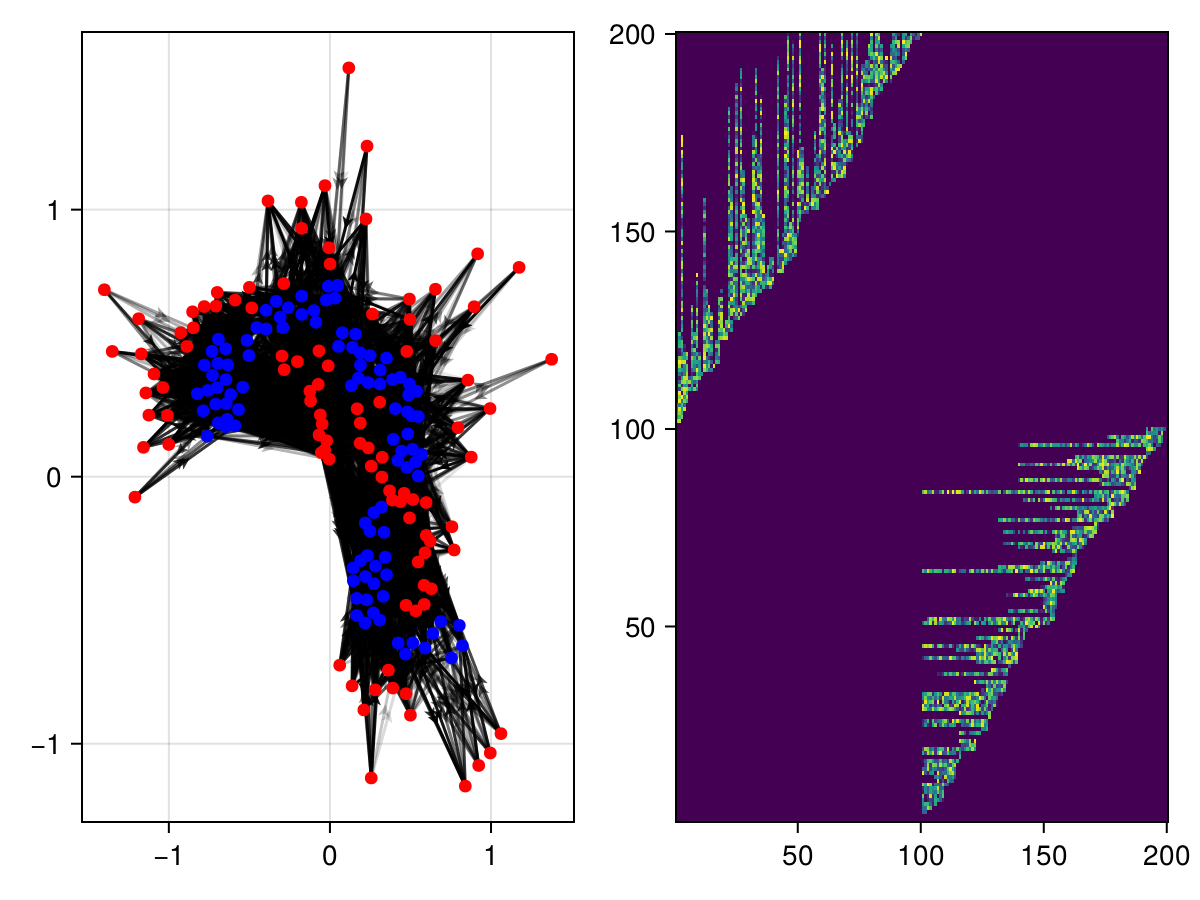

In [10]:
A = get_A(a)
tl = get_TL(A)

c = vcat(fill(:red,N),fill(:blue,M))
# c[sum(A, dims = 1)[:] .== 0] .= :green
# c[sum(A, dims = 2)[:] .== 0] .= :orange
# c = [(v, 0.9 + 0.1*(tl[i] / maximum(tl)) ) for (i,v) = enumerate(c)]

    
g = SimpleWeightedDiGraph(A)
# c = get_TL(A)

ec = [(:black, i.weight) for i = collect(edges(g))]
layout = Spring() #mylayout(g, N, M, A)

f = Figure()
graphplot!(Axis(f[1,1]), g, layout = layout, node_color = c, edge_color = ec)
heatmap!(Axis(f[1,2]), A)
f

In [11]:
#plotting layout
function mylayout(g, N, M, A)
    #get avg for consumers
    con_indx = [findall(A[(N+1):end,i] .!= 0) for i = 1:N]
    con_wt = [filter(x -> x != 0, A[(N+1):end, i]) for i = 1:N]
    con_wt = [con_wt[i] ./ sum(con_wt[i]) for i = 1:N]
    con_mean = [sum(con_indx[i] .* con_wt[i]) for i = 1:N]
    
    sN = sum(A, dims = 2)[1:N]

    
    xs = vcat(con_mean, 1:M)
    ys = vcat(ones(N), fill(0.0, M))
   

    return Point.(zip(xs, ys))
end


function plot_com!(com, ax; ns = 10, as = 0.1)
    A = get_A(com)
    c = vcat(fill(:red,com.N),fill(:blue,com.M))
    c[com.N+1] = :green
    c[end] = :green

    ns = ns .* ones(com.N + com.M)
    as = as .* sum(A .> 0)
    
    g = SimpleWeightedDiGraph(A)
    ec = [(:black, max(i.weight,0.1)) for i = collect(edges(g))]
    layout = Spring()#mylayout(g, N, M, A)
    graphplot!(ax, g, layout = layout, node_color = c, node_size = ns, edge_color = ec, arrow_size = as)
end

plot_com! (generic function with 1 method)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


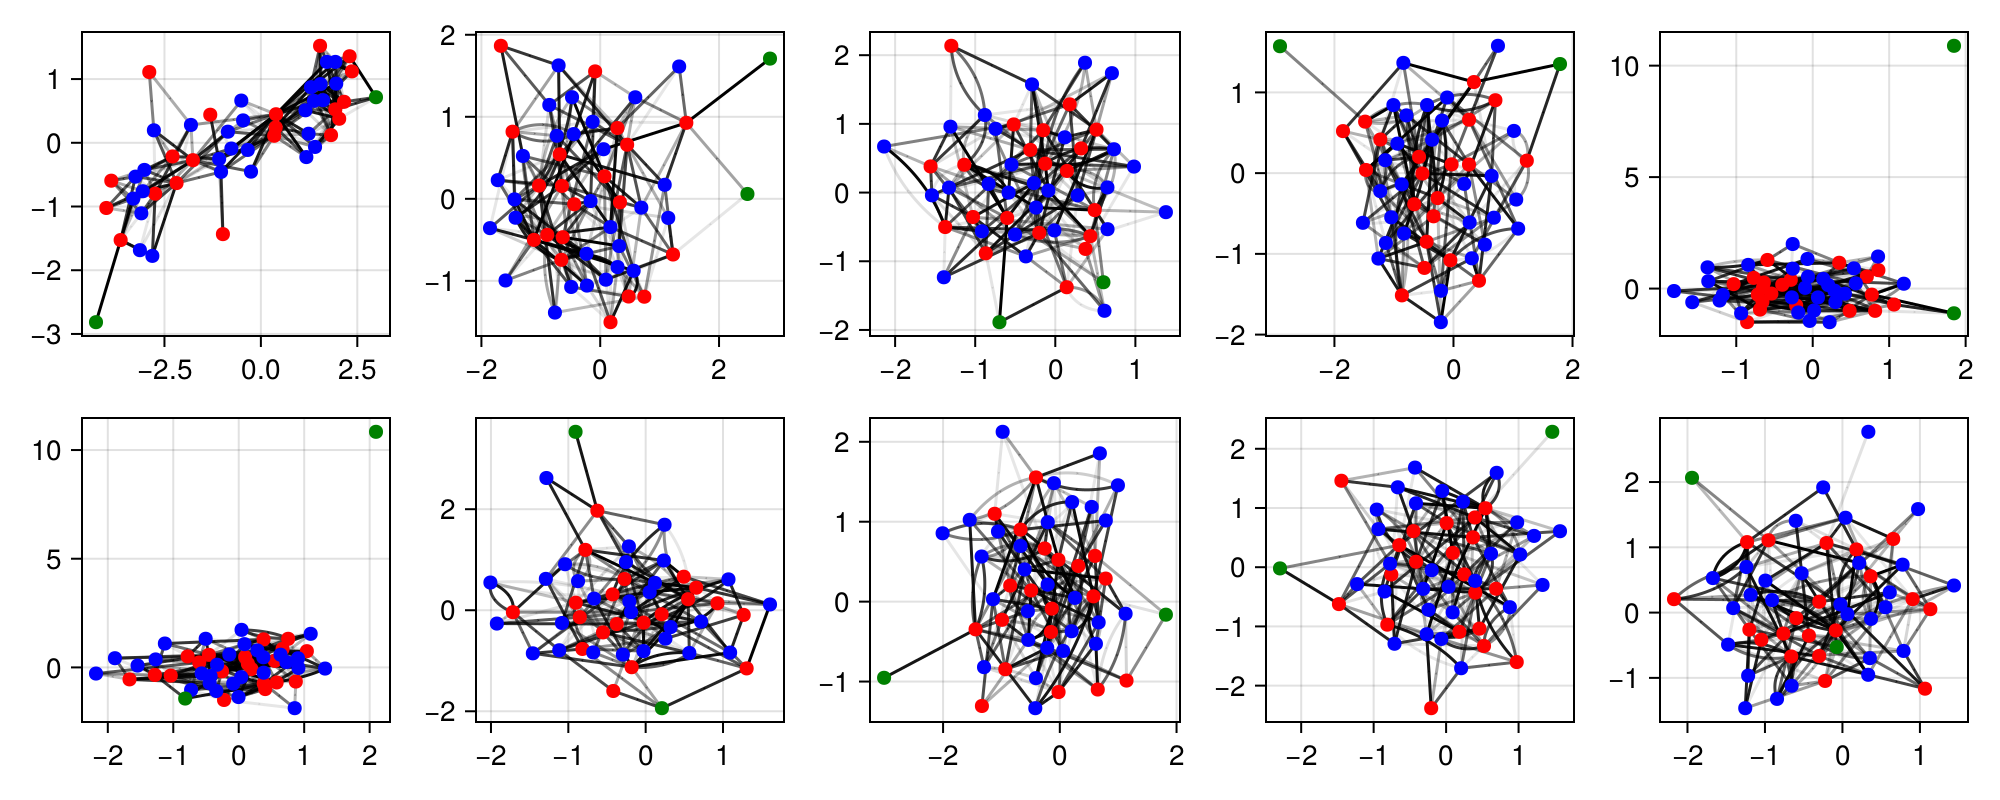

In [12]:
f = Figure(resolution = (1000, 400))
ax = hcat([[Axis(f[j,i]) for i = 1:5] for j = 1:2]...)

Random.seed!(1)
N,M = 20,30
C = 0.15

com = rand_com(N,M,C)
while !check_connected(com)
    com = rand_com(N,M, C)
end

for i = 1:10
    plot_com!(com, ax[i], as = 0.01)
    [shuffle!(com) for i = 1:(100)]
end
f

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


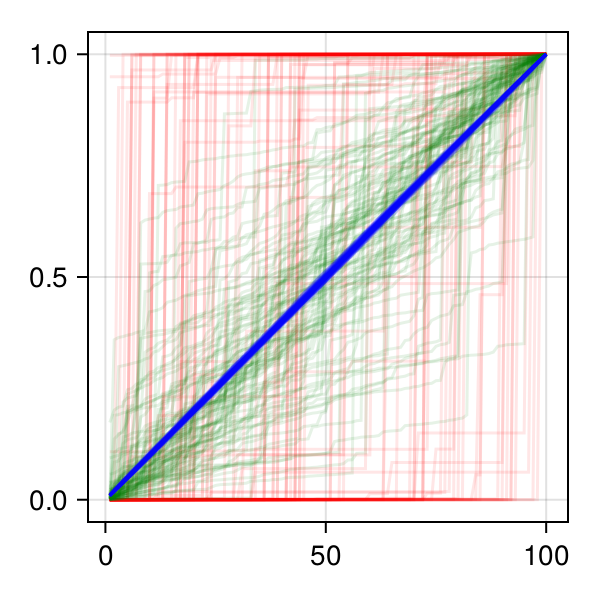

In [13]:
# Grainyness
function get_n(α,S)
    dG = Pareto(α,1)
    G = rand(dG, S)
    n = [sum(G[1:i]) / sum(G) for i = 1:S]
    return(n)
end

f = Figure(resolution = (300,300))
ax = Axis(f[1,1])
[lines!(ax, get_n(0.1,100), color = ("red", 0.1)) for i = 1:100]
[lines!(ax, get_n(1,100), color = ("green", 0.1)) for i = 1:100]
[lines!(ax, get_n(10,100), color = ("blue", 0.1)) for i = 1:100]

f

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


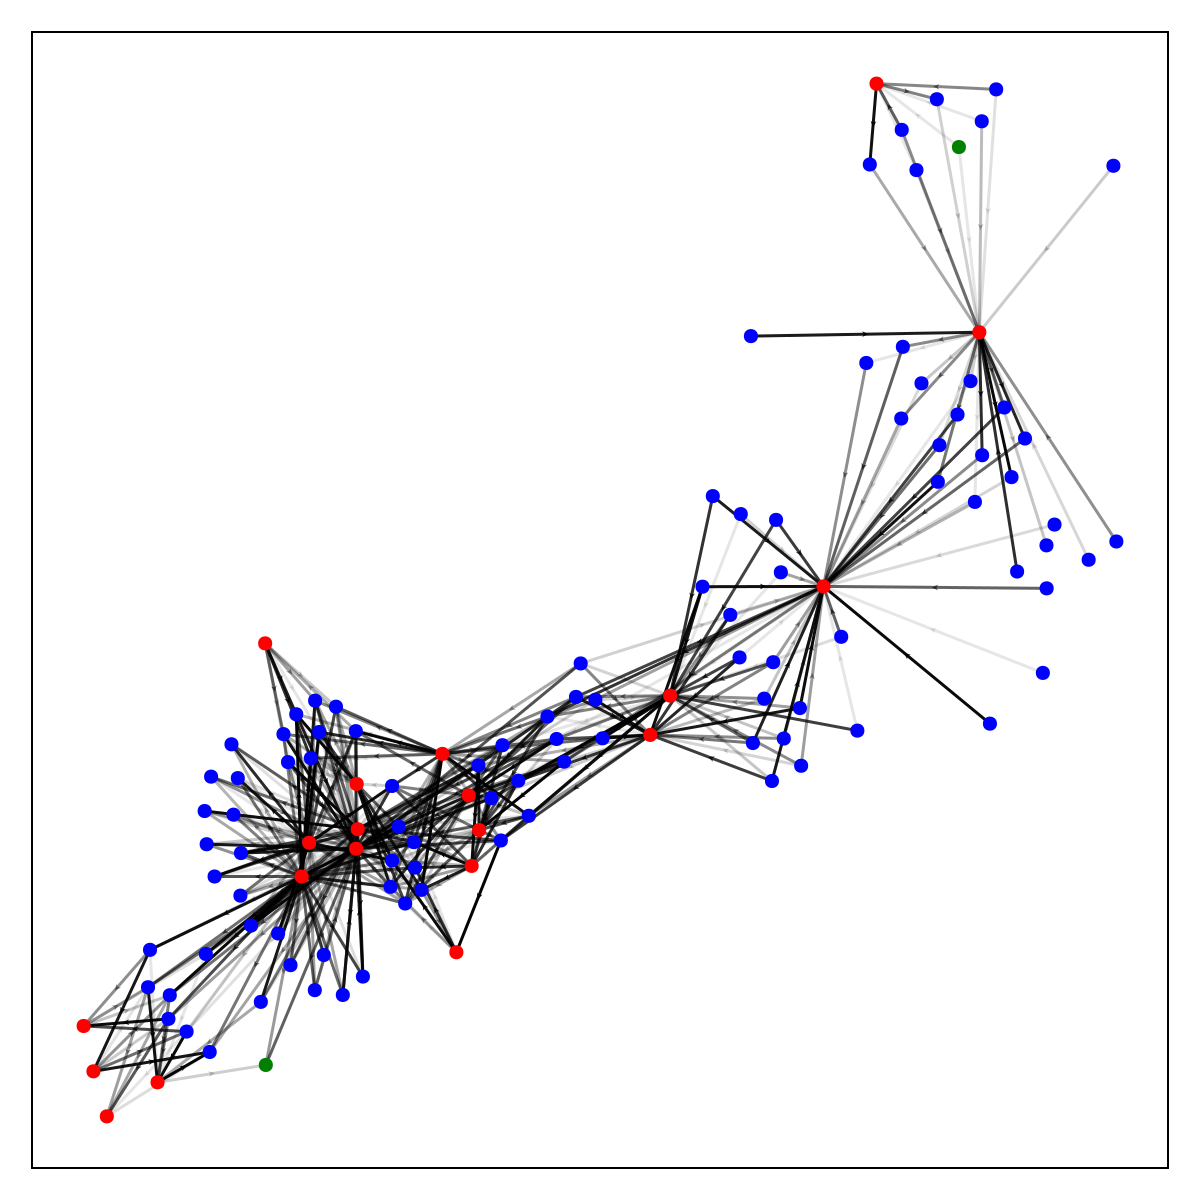

In [14]:
#Random.seed!(1)
N,M = 20,100
C = 0.1

nc = get_n(1.0,N)
nr = get_n(1.0,M)

com = rand_com(N, M, C, nc)
while !check_connected(com)
    com = rand_com(N, M, C, nc)
end


f = Figure(resolution = (600,600))
ax = Axis(f[1,1])

plot_com!(com, ax, as = 0.01)

hidedecorations!(ax)

f

# Dynamic Parameters

First we look at the effects of the dynamic/exponetial parameters in the model. Here I simulate 10000 systems with different parameter values which we can then correlate with the stability metrics

In [12]:
function get_param_e_mean(p::MiCRM_stability.Parameters)
    fe = fieldnames(MiCRM_stability.exponential_params)
    ue = mean.(getfield.(Ref(p.e), fe))
    vcat(ue...) 
end

function get_param_s_mean(p::MiCRM_stability.Parameters)
    fs = fieldnames(MiCRM_stability.structural_params)
    us = mean.(getfield.(Ref(p.s), fs))
    vcat(us...) 
end


function get_exponential_parameters(N,M)
    σ = 0.1
    gx = rand(Uniform(0.0, 1.0)) .+ zeros(N)
    gs = rand(Uniform(-2,2)) .+ rand(Uniform(-σ,σ), N)
    gw = rand(Uniform(-2,2)) .+ rand(Uniform(-σ,σ), N)
    mx = rand(Uniform(0, 1.0)) .+ zeros(N)
    
    fy = ones(N,M)
    hy = -ones(N,M)
    
    λy = zeros(N,M) 
    ωy = zeros(N,M)


    iy = rand(Uniform(0.0,1.0)) .+ rand(Uniform(-σ,σ), M)
    oy = rand(Uniform(0.5,1.5)) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

get_exponential_parameters (generic function with 1 method)

In [13]:
N,M = 50,100
C = 0.2
Ncom = 1e1 |> Int
Nrep = 1

k = [0]

p_names = vcat(fieldnames(MiCRM_stability.exponential_params)..., fieldnames(MiCRM_stability.structural_params)...)

λ_mat = zeros(Ncom, Nrep)
r_mat = zeros(Ncom, Nrep)
p_mat = Array{Float64,3}(undef, Ncom, Nrep, length(p_names))
c_mat = Array{MiCRM_stability.Community, 1}(undef, Ncom)

Threads.@threads for i = 1:Ncom
    k[1] += 1
    if k[1] % 100 == 0
        print("\r", k)
    end

    #generate inital community
    f = true
    c = 0
    while f
        c = MiCRM_stability.rand_community(N,M,C)        
        f = !check_connected(c)
    end

    #copy matrix
    c_mat[i] = deepcopy(c)

    #calculate trophic coherence
    TC = get_TC(get_A(c_mat[i]))

    # #save structural metrics
    # s_vec = [mean(pairwise(Jaccard(), eachcol(c.U), eachcol(c.U))), 
    #          mean(pairwise(Jaccard(), eachcol(c.U), eachcol(c.L))),
    #         N,M, mean(c.U .!= 0), N/M, TC, 0, 0]
    
    #allocate jacobian
    J = zeros(c.N+c.M,c.N+c.M)    
    #loop over reps
    for j = 1:Nrep
        
        #generate parameters
        sp = MiCRM_stability.get_structural_params(c.U, c.L, c.N, c.M)
        ep = get_exponential_parameters(c.N, c.M)
        p = MiCRM_stability.Parameters(c.N,c.M,sp,ep)

        #calculate stabiltiy
        MiCRM_stability.jacobian!(p, J)
        λ_mat[i,j] = get_real(eigsolve(J, 1, (:LR))[1][1])

        #save parameters used
        p_mat[i,j,:] .= vcat(get_param_e_mean(p), get_param_s_mean(p))
    end
end

println("\n", sum([l < 1e-5 for l = λ_mat[:]]) )

LoadError: TaskFailedException

[91m    nested task error: [39mMethodError: no method matching rand_community(::Int64, ::Int64, ::Float64)
    
    [0mClosest candidates are:
    [0m  rand_community(::Any, ::Any, ::Any, [91m::Any[39m, [91m::Any[39m)
    [0m[90m   @[39m [35mMiCRM_stability[39m [90m~/.julia/dev/MiCRM_stability/src/[39m[90m[4mniche_model.jl:4[24m[39m
    
    Stacktrace:
     [1] [0m[1mmacro expansion[22m
    [90m   @[39m [90m./[39m[90m[4mIn[13]:25[24m[39m[90m [inlined][39m
     [2] [0m[1m(::var"#56#threadsfor_fun#35"{var"#56#threadsfor_fun#34#36"{UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [36mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
     [3] [0m[1m#56#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
     [4] [0m[1m(::Base.Threads.var"#1#2"{var"#56#threadsfor_fun#35"{var"#56#threadsfor_fun#34#36"{UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m

...and 9 more exceptions.


In [231]:
# save("../Results/data/dynamic_stabiltiy.jld2", Dict("p" => p_mat, "r" => r_mat, "l" => λ_mat, "c" => c_mat))
res = load("../Results/data/dynamic_stabiltiy.jld2")

λ_mat = res["l"]
p_mat = res["p"];

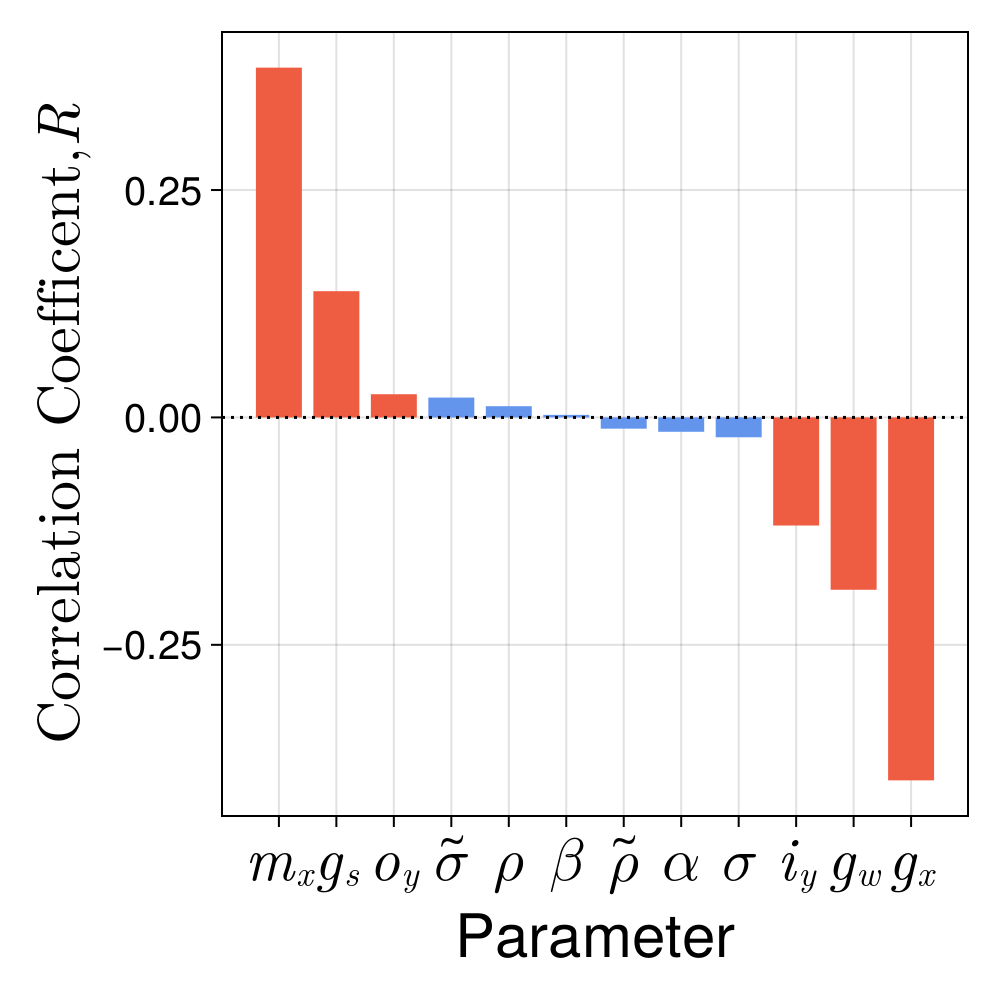

In [120]:
# plotting
#get param names
fe = fieldnames(MiCRM_stability.exponential_params)
fs = fieldnames(MiCRM_stability.structural_params)

#latex names
fe_L = [L"g_x",L"g_s",L"g_w",L"m_x",L"f_y",L"h_y",L"\lambda_y",L"\omega_y",L"i_y",L"o_y"]
fs_L = [L"\alpha",L"\beta",L"\rho",L"\tilde{\rho}",L"\sigma",L"\tilde{\sigma}",L"\gamma",L"\eta",L"\chi",L"\phi"]

f = Figure(size = (500,500))

m = 1

#stability correlation
stab = (λ_mat .< -1e-5)[:,m, 1]
cor_vec = [cor(stab, p_mat[:,m, 1,p]) for p = 1:size(p_mat)[4]]
cor_vec[3] *= -1
#select parameters and sort by correlation
p_ind = filter(x -> x <= 16, findall(.!isnan.(cor_vec) .& (abs.(cor_vec) .> 0.0)))
p_ind = p_ind[sortperm(cor_vec[p_ind], rev = true)]

#set up ax with correct labels
ax2 = Axis(f[1,m], xlabel = "Parameter", xlabelsize = 30,
    ylabel = L"\text{Correlation Coefficent}, R",ylabelsize = 30,
    xticks = ((1:length(p_ind)), vcat(fe_L..., fs_L...)[p_ind]), xticklabelsize = 30, yticklabelsize = 20)

#get color
c = ["tomato2", "cornflowerblue"]
c_vec = vcat(fill(c[1], length(fe_L)),fill(c[2], length(fs_L)))

#plot
barplot!(ax2, (1:length(p_ind)), cor_vec[p_ind], color = c_vec[p_ind])
hlines!(ax2, [0.0], linestyle = :dot, color = :black)

f

In [121]:
save("../Results/Figures/stability_correlations.png", f)

CairoMakie.Screen{IMAGE}


In [122]:
#exampe matracies
N = 100
M = 100
C = 0.2

Urand = MiCRM_stability.rand_community(N,M,C,10,10).U
Unich = MiCRM_stability.niche_community(N,M,C).U

Mclass = 5
#group sizes
Min = M / Mclass
Mout = M - Min
Co = 0.1
Ci = (M*C - Co*Mout) / Min

Umodu = MiCRM_stability.modular_community(N,M,Mclass, 0.0, 0.0, Co, Ci, Co, Co, Ci).U

Unest = MiCRM_stability.nested_community(N,M,-1, 1.4).U;

Uvec = [Urand,Unich,Umodu,Unest]

4-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.29196090077213455 0.0 … 0.0 0.0; … ; 0.9380242858972503 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.9151571704997369]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.7543190173879633 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.6908376490319185 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.1422015762064781 0.3589696062497153; 0.0 0.0 … 0.21698885635552112 0.7116688196858506; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

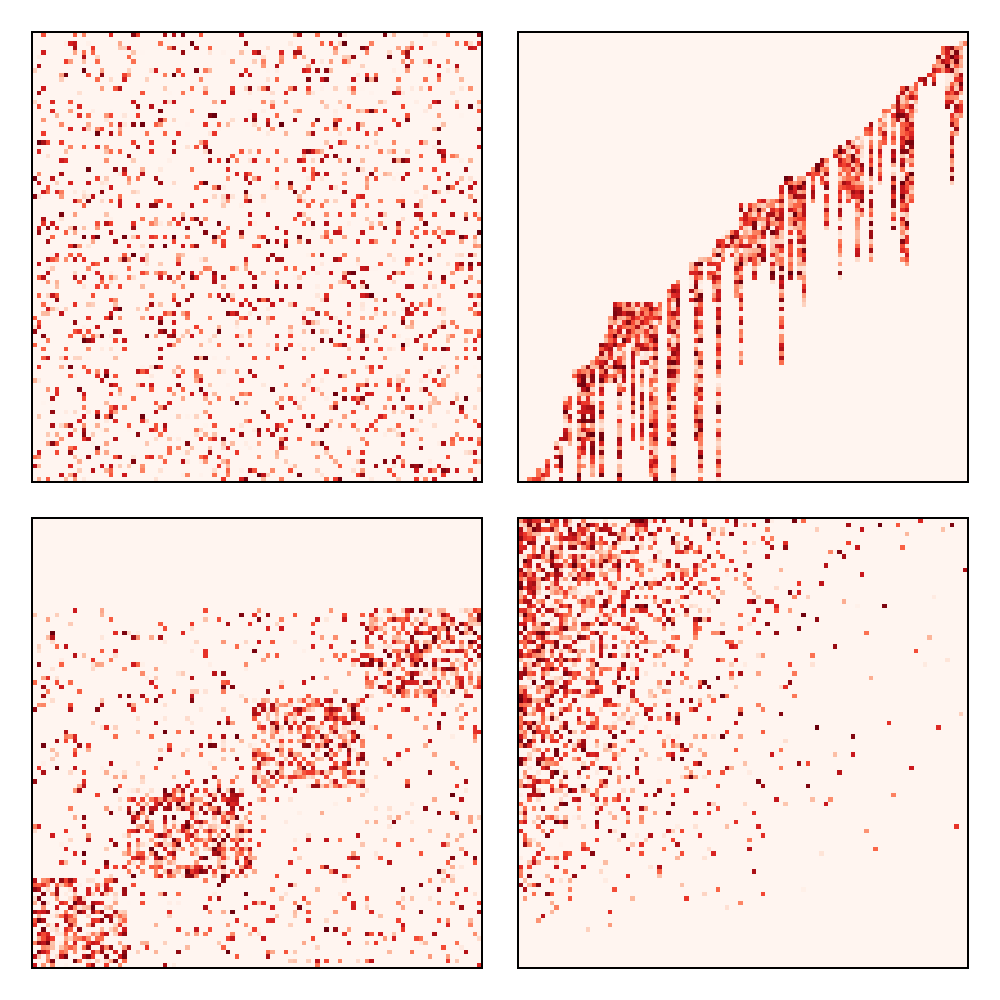

In [123]:
f = Figure(size = (500,500))
ax = [Axis(f[(i-1) ÷ 2 , (i-1) % 2]) for i = 1:4]

cmap = ColorSchemes

[heatmap!(ax[i], Uvec[i], colormap = :Reds) for i = 1:4]

hidedecorations!.(f.content)

f

In [124]:
save("../Results/Figures/Umat.png", f)

CairoMakie.Screen{IMAGE}


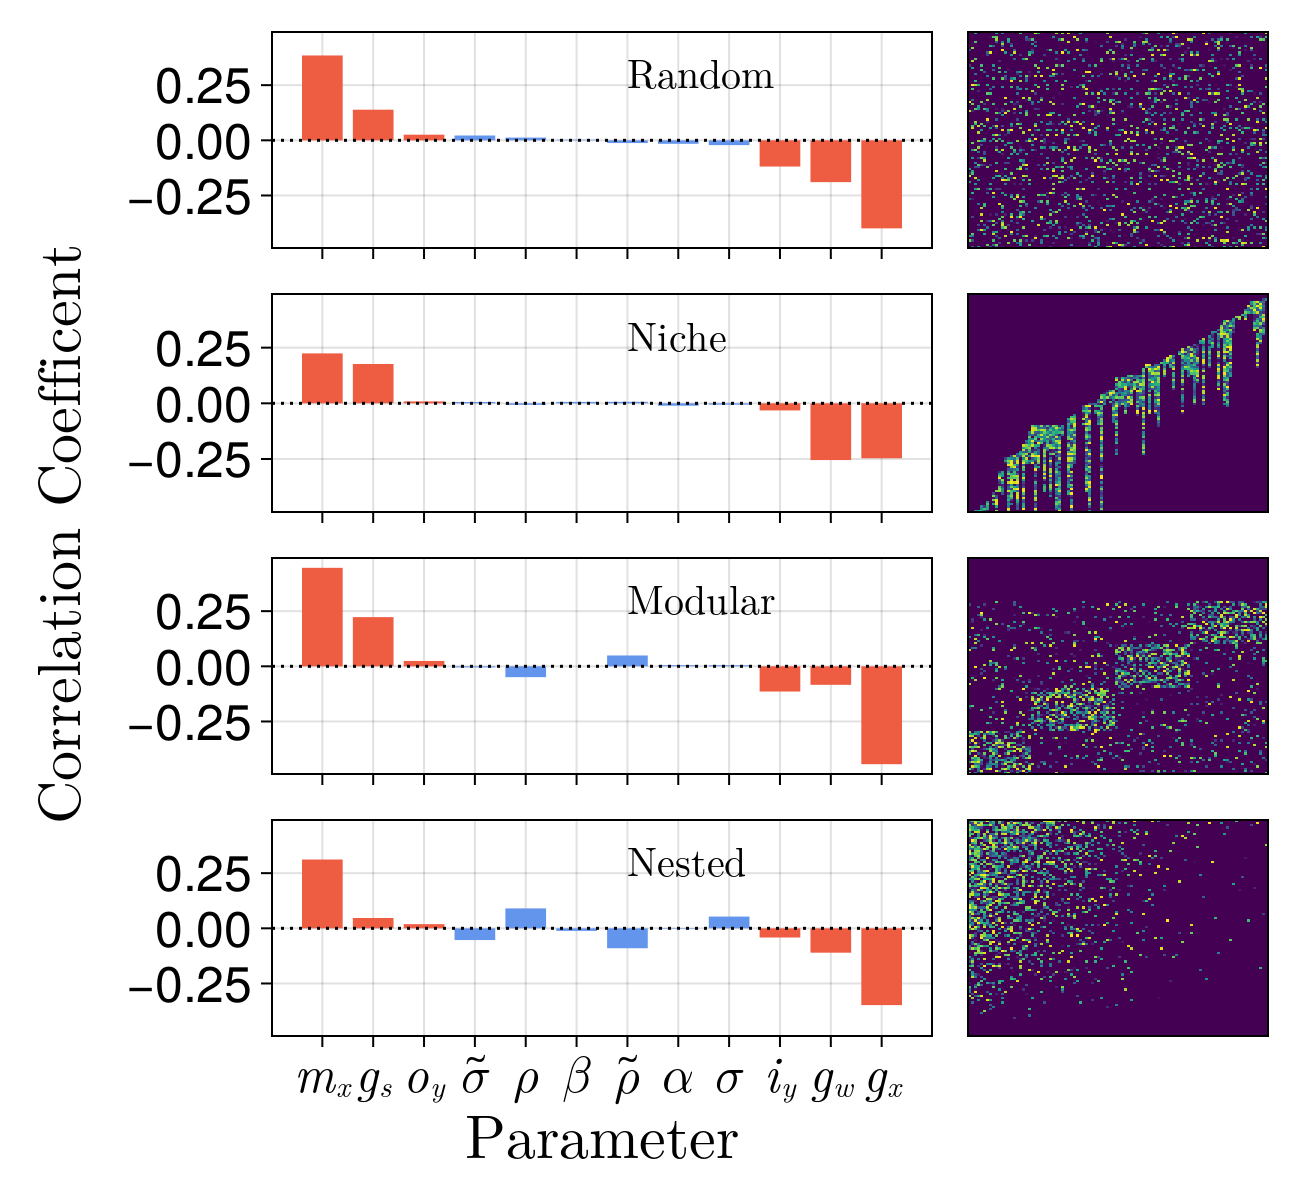

In [125]:
#plotting
#get param names
fe = fieldnames(MiCRM_stability.exponential_params)
fs = fieldnames(MiCRM_stability.structural_params)

#latex names
fe_L = [L"g_x",L"g_s",L"g_w",L"m_x",L"f_y",L"h_y",L"\lambda_y",L"\omega_y",L"i_y",L"o_y"]
fs_L = [L"\alpha",L"\beta",L"\rho",L"\tilde{\rho}",L"\sigma",L"\tilde{\sigma}",L"\gamma",L"\eta",L"\chi",L"\phi"]
models = [L"\text{Random}",L"\text{Niche}",L"\text{Modular}",L"\text{Nested}"]
f = Figure(size = (650,600))

for m = 1:4
    #stability correlation
    stab = (λ_mat .< -1e-5)[:,m, 1]
    cor_vec = [cor(stab, p_mat[:,m, 1,p]) for p = 1:size(p_mat)[4]]
    cor_vec[3] *= -1
    #select parameters and sort by correlation
    # p_ind = filter(x -> x <= 16, findall(.!isnan.(cor_vec) .& (abs.(cor_vec) .> 0.0)))
    # p_ind = p_ind[sortperm(cor_vec[p_ind], rev = true)]
    
    #set up ax with correct labels
    ax = Axis(f[1m,1], xlabel = L"\text{Parameter}", xlabelsize = 30,ylabelsize = 30,
        xticks = ((1:length(p_ind)), vcat(fe_L..., fs_L...)[p_ind]), xticklabelsize = 25, yticklabelsize = 25)
    
    if m == 4
    
    else
        hidexdecorations!(ax,ticks = false, grid = false)
    end
    #get color
    c = ["tomato2", "cornflowerblue"]
    c_vec = vcat(fill(c[1], length(fe_L)),fill(c[2], length(fs_L)))
    
    #plot
    barplot!(ax, (1:length(p_ind)), cor_vec[p_ind], color = c_vec[p_ind])
    text!(ax, 7, 0.2, text = models[m], fontsize = 20)
    hlines!(ax, [0.0], linestyle = :dot, color = :black)
end

f.content[end].xticks = ((1:length(p_ind)), vcat(fe_L..., fs_L...)[p_ind])
linkyaxes!(f.content...)
Label(f[1:4, 0], L"\text{Correlation Coefficent}", rotation = pi/2, fontsize = 30)

for m = 1:4
    ax = Axis(f[m,2])
    hidedecorations!(ax)
    heatmap!(ax, Uvec[m])
end

colsize!(f.layout, 2, 150)

f

In [ ]:
#just Umatricies

In [87]:
save("../Results/Figures/stability_mode_correlations.png", f)

CairoMakie.Screen{IMAGE}


Overal the Here we can see the effect of the various parameters. 

Positively affecting stability are the sensitvtiy of contributions f_{ia}^{(y)}, the sensitvity of uptake to substrate ammount $g_{i}^{(s)}$, the sesitvtiy of consumer mortality $m_i^{x}$ and the sensitvity of resource outflow $o_{a}^{y}$.

Negatively affecting stabiltiy is the sensitvity of leakage proportion to resource abundance $\lambda_i^{(y)}$, the sensitvity of uptake to waste and consumer abundance $g_{i}^{(w)}, g_{i}^{(x)}$ as well as the sensitvtiy of resource inflow $i_a^{(y)}$

These results make sense and suggest two mechanisms for stability. 

First is the self-inhibition through which consumers and resources are naturaly stable due to the self-dynamics. This is seen in the stabilising effects of the mortality and loss terms $m_i^{(x)}$ and $o_a^{(y)}$ the destabilising effects of the sensitity of uptake and resource inflow $g_{i}^{(x)}$ and $i_a^{(y)}$. These terms all appear in the diagonal elements of the Jacobian and thus promote stability by reducing their values (thus shifting all eigenvalues towards negative values). 

Second is the capacity of consumers to respond to resource perturbations, shown in the sensitivtiy of uptake to substrates and waste products $g_{i}^{(s)},g_{i}^{(w)}$ which stabilise and destabilise respectively. This suggests an additional mechanism of stabilisation which depends on the abiltiy of consumers to quickly respond to changes in resource concentration. Waste product inhibition prevents this here and is thus a destabiltiying force. This is further supported by the switching terms $f_{ia}^{(y)}$ and $h_{ia}^{(y)}$ which determine the sensitvtiy with which consumers switch their uptake profiles based on resource abundance.

## Switching Parameters

In [126]:
function get_exponential_parameters(N,M)
    σ = 0.1
    gx = 0.9ones(N) .+ rand(Uniform(-σ,σ), N)
    gs = 2ones(N) .+ rand(Uniform(-σ,σ), N)
    gw = -ones(N) .+ rand(Uniform(-σ,σ), N)
    mx = 1.1ones(N) .+ rand(Uniform(-σ,σ), N)
    
    fy = rand(Uniform(0,2)) .+ rand(Uniform(-σ,σ),N,M)
    hy = rand(Uniform(-2,0)) .+ rand(Uniform(-σ,σ),N,M)
    
    λy = rand(Uniform(-2,2)) .+ rand(Uniform(-σ,σ),N,M)
    ωy = rand(Uniform(-2,2)) .+ rand(Uniform(-σ,σ),N,M)

    iy = zeros(M) 
    oy = ones(M) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

get_exponential_parameters (generic function with 1 method)

In [ ]:
N,M = 50,100
C = 0.2
Ncom = 100000
Nrep = 1

c = 0

k = [0]

λ_mat = zeros(Ncom, Nrep)
p_mat = Array{Float64,3}(undef, Ncom, Nrep,27)
s_mat = Array{Tuple,2}(undef, Ncom, Nrep)
p = 0



Threads.@threads for i = 1:Ncom
    # N = 50 #rand(1:100)
    # M = 50 #rand(1:100)
    
    k[1] += 1
    if k[1] % 100 == 0
        print("\r", k)
    end
    J = zeros(N+M,N+M)
        
    f = true
    c = 0
    while f
        c = rand_com(N,M,C)
        f = !check_connected(c)
    end
        
    s_vec = [mean(pairwise(Jaccard(), eachcol(c.U), eachcol(c.U))), 
             mean(pairwise(Jaccard(), eachcol(c.U), eachcol(c.L))),
            N,M,mean(c.U),N/M, 0]
    
    for j = 1:Nrep
        sp = MiCRM_stability.get_structural_params(c.U, c.L, c.N, c.M)
        ep = get_exponential_parameters(c.N, c.M)
        p = MiCRM_stability.Parameters(N,M,sp,ep)
        
        s_vec[end] = mean(p.e.ωy ./ (p.e.λy .+ p.e.ωy))
        
        MiCRM_stability.jacobian!(p, J)
        λ_mat[i,j] = get_real(eigsolve(J, 1, (:LR))[1][1])
        p_mat[i,j,:] .= vcat(get_param_e_mean(p),get_param_s_mean(p), s_vec)
    end
end

println("\n", sum([l < 1e-5 for l = λ_mat[:]]) )

In [767]:
res = load("../Results/data/switching_stabiltiy.jld2")

λ_mat = res["l"]
p_mat = res["p"];

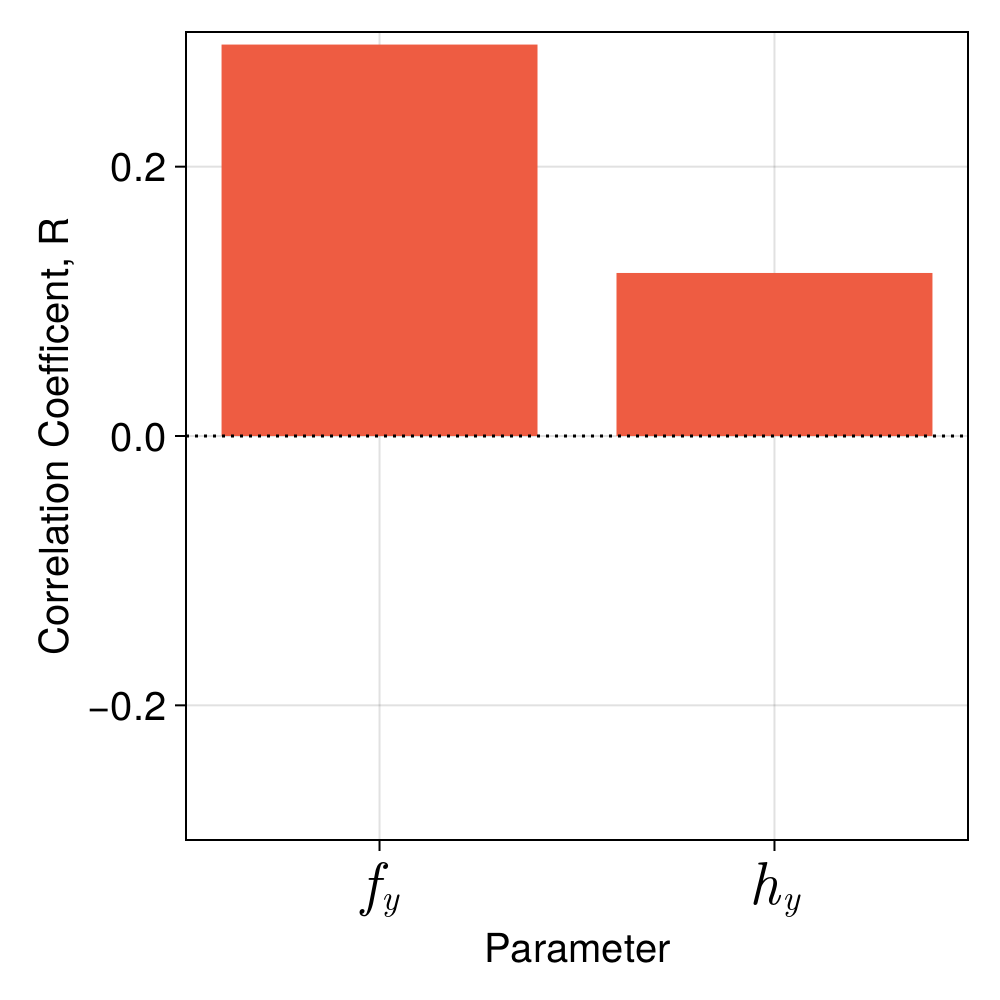

In [772]:
#plotting
m = 4
l = p_mat[:,m,1,7]
w = p_mat[:,m,1,8]
L = - w ./ (l .- w);

p_mat[:,m,1,8] .= L

#get param names
fe = fieldnames(MiCRM_stability.exponential_params)
fs = fieldnames(MiCRM_stability.structural_params)

#latex names
fe_L = [L"g_x",L"g_s",L"g_w",L"m_x",L"f_y",L"h_y",L"\lambda_y",L"\Lambda^*",L"i_x",L"o_x"]
fs_L = [L"\alpha",L"\beta",L"\rho",L"\tilde{\rho}",L"\sigma",L"\tilde{\sigma}",L"\gamma",L"\eta",L"\chi",L"\phi"]


#get param names
ind = [5,6]
p_names = vcat(fe_L...)[ind]

f = Figure(size = (500,500))


# # #stability correlation
stab = (λ_mat .< -1e-5)[:,m,1]
cor_vec = [cor(stab, p_mat[:,m,1,p]) for p = ind]
s_ind = sortperm(cor_vec, rev=true)
ax2 = Axis(f[1,1], xlabel = "Parameter", ylabel = "Correlation Coefficent, R",
    xticks = (1:(length(p_names)), string.(p_names)[s_ind]), xlabelsize = 20, ylabelsize = 20, xticklabelsize = 30, yticklabelsize=20)

barplot!(ax2, cor_vec[s_ind], color = "tomato2")
hlines!(ax2, [0.0], linestyle = :dot, color = :black)

ylims!(ax2, -0.3,0.3)
f

In [30]:
save("../Results/Figures/switching_correlations.png", f)

CairoMakie.Screen{IMAGE}


The resource switching seems to match the perturbation minimisation idea. It is stabilising to have switching towards abundant resources and destabilising to have uptake that is sensitive to waste products. 

Overall leakage is destabilising, leaking a higher proportion of resources into the environment leads to unstable communties. In particular the sensitvtiy of the leakage proportion 

# Structure

## Commiunity size and connectance

First we look at how the size and connectance of communities affects thier stabiltiy

In [215]:
function get_exponential_parameters(N,M)
    σ = 0.1
    gx = 0.95 .* ones(N) .+ rand(Uniform(-σ,σ), N)
    gs = 2ones(N) .+ rand(Uniform(-σ,σ), N)
    gw = zeros(N) #.+ rand(Uniform(-σ,σ), N)
    mx = ones(N) .+ rand(Uniform(-σ,σ), N)
    
    fy = ones(N,M)
    hy = -ones(N,M)
    
    λy = zeros(N,M)
    ωy = zeros(N,M)

    iy = zeros(M)
    oy = ones(M) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

function get_exponential_parameters(N,M)
    σ = 0.1
    gx = 0.95 .* ones(N) .+ rand(Uniform(-σ,σ), N)
    gs = ones(N) .+ rand(Uniform(-0.5,0.5), N)
    gw = zeros(N) 
    mx = 1.1ones(N) .+ rand(Uniform(-σ,σ), N)
    
    fy = ones(N,M)
    hy = -ones(N,M)
    
    λy = zeros(N,M)
    ωy = zeros(N,M)

    iy = zeros(M)
    oy = ones(M) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

get_exponential_parameters (generic function with 1 method)

In [236]:
res = load("../Results/data/size_stabiltiy_random3.jld2")

λ_mat = res["l"]
N_mat = res["N"];
M_mat = res["M"];

Nrep = 250
NC = 1
n = 40
m = 40

minS = log(25.1)
maxS = log(250.1)

N_vec = exp.(range(minS, maxS, length = n))
M_vec = exp.(range(minS, maxS, length = m));

odds(x) = log(x / (1-x))

thresh = 1e-10
m = 1

s_mat = mean(λ_mat .< -thresh, dims = 5)[:,:,m,1,1]
u_mat = mean((λ_mat) .> thresh, dims = 5)[:,:,m,1,1]
z_mat = mean(-thresh .< (λ_mat) .< thresh, dims = 5)[:,:,m,1,1];


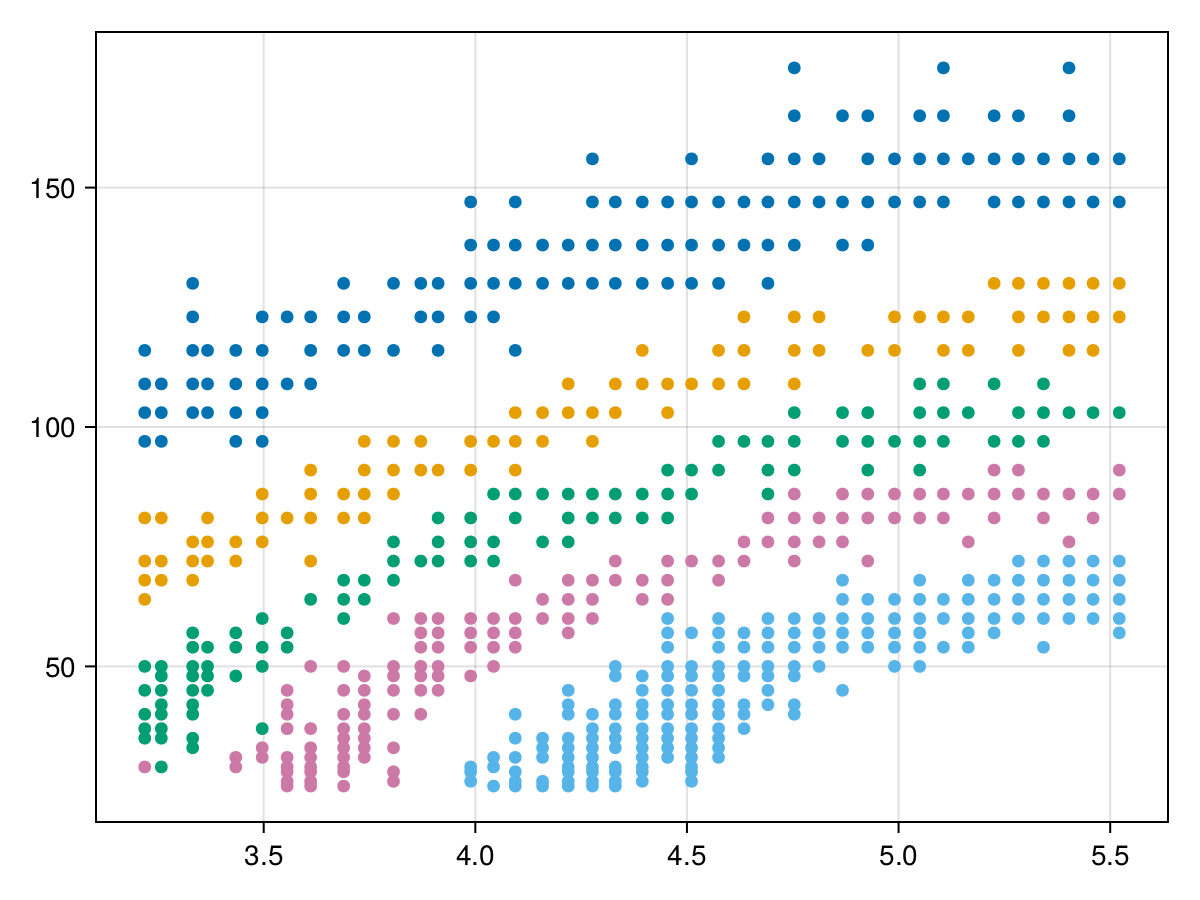

In [237]:
#get isoclines
f = Figure()
ax = Axis(f[1,1])

Np = 5
coef = Vector{Any}(undef, Np)
M_vec_bounded = Vector{Any}(undef, Np)
model(x,p) = p[1] .+ x .* p[2]
p0 = [0.0, 1.0]


pvec = range(0.15, 0.9, length = Np)

for i = 1:Np
    x =  pvec[i] #[0.2,0.4,0.6,0.8][i]
    iso_mat = x-0.05 .< s_mat .< x + 0.05
    N = N_mat[:,:,1,1,1][iso_mat]
    M = M_mat[:,:,1,1,1][iso_mat]

    M_vec_bounded[i] = M
    
    coef[i] = curve_fit(model, log.(M), N, p0)
    
    plot!(ax, log.(M), (N) )
    # ablines!(ax, coef[i].param[1], coef[i].param[2])
    # lines!(ax, log.(M), (coef[i].param[1] .+ log.(M) .* coef[i].param[2]))
end

f

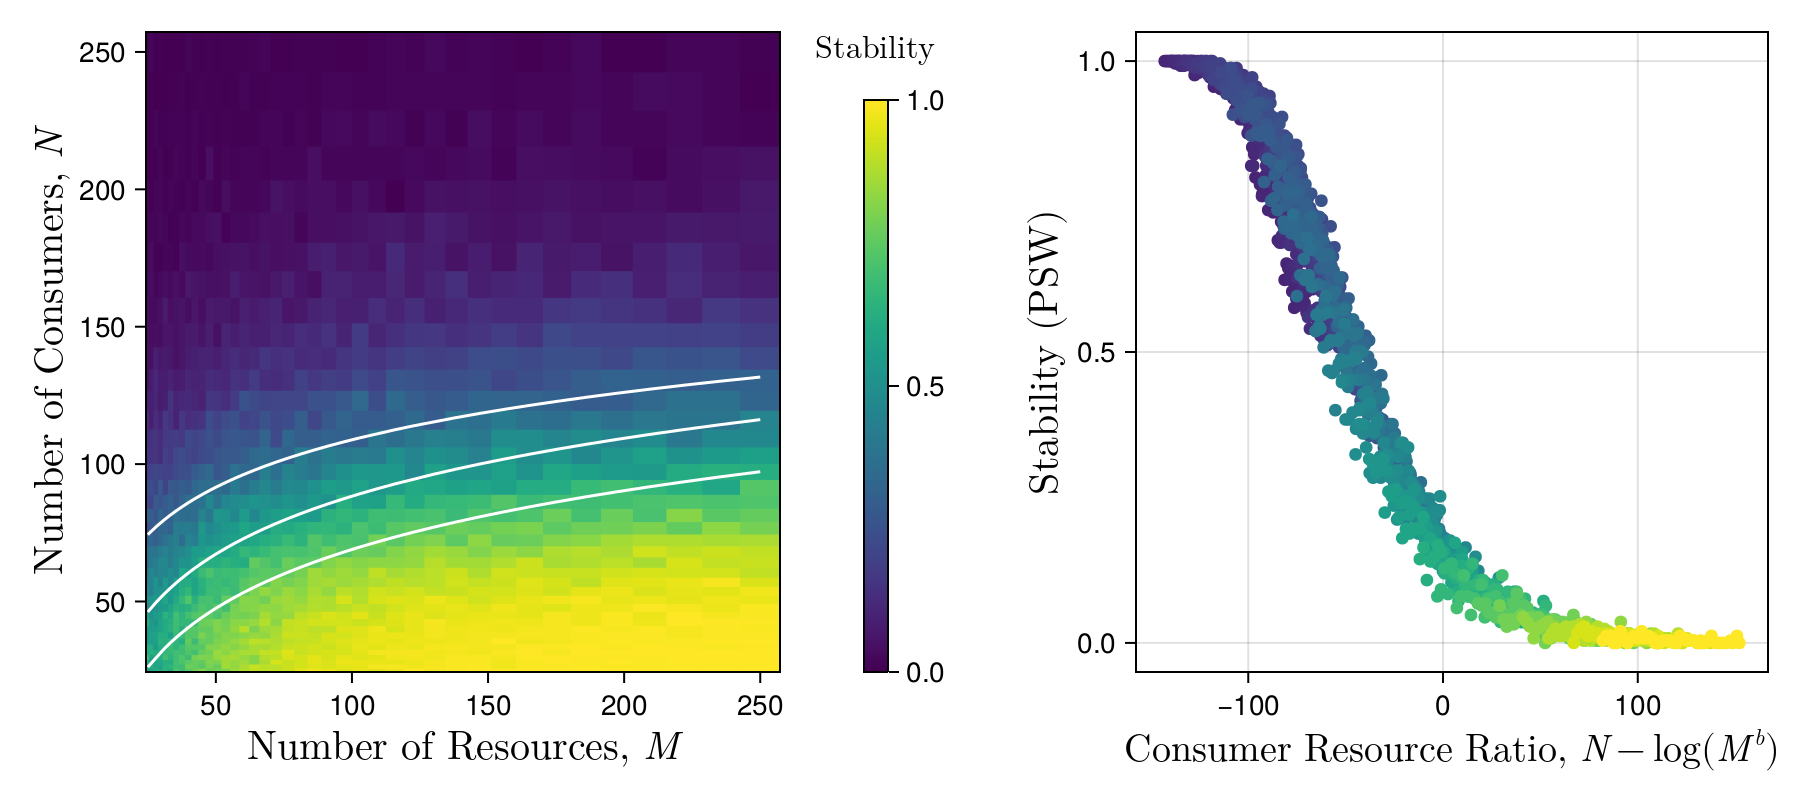

In [328]:

f = Figure(size = (900,400))

#heatmap
ax = Axis(f[1:2,1], xlabel = L"\text{Number of Resources}, \ (M", ylabel = L"\text{Number of Consumers}, \ (N", xlabelsize = 20, ylabelsize = 20)
heatmap!(ax, N_vec, M_vec, s_mat')
# ablines!(ax,0,1,color = ("white", 0.5))


[lines!(ax, M_vec_bounded[i], coef[i].param[1] .+ (coef[i].param[2] .* log.(M_vec_bounded[i])), color = :white) for i = 2:4]

# axislegend(ax, framevisible = false, labelcolor = "white",labelsize = 20, merge = true)
Label(f[1,2], L"\text{Stability}", fontsize = 16)
Colorbar(f[2,2])


# #stability plot
ax = Axis(f[1:2,3], xlabel = L"\text{Consumer Resource Ratio,} \ ( N - \log(M^b)", ylabel = L"\text{Stability (PSW)}", xlabelsize = 19, ylabelsize = 20)
x = ((N_mat[:,:,1,1,1])) .- log.(M_mat[:,:,1,1,1] .^ coef[3].param[2]) 

# x = (N_mat[:,:,1,1,1]) .- (M_mat[:,:,1,1,1]) 

# [s_mat[:,i] .= s_mat[:,i] ./ maximum(s_mat[:,i]) for i = 1:m]
for i = 1:n
    # scatter!(ax, log.(x[:,i]), s_mat[:,i], color = M_mat[:,i,1,1,1][:], colorrange = (0,250))
    scatter!(ax, (x[i,:])  , (s_mat[i,:]), color = N_mat[i,:,1,1,1][:], colorrange = (0,250))
    # scatter!(ax, x[i,:], s_mat[i,:], color = M_mat[i,:,1,1,1][:], colorrange = (0,250))

end

f

In [331]:
 coef[2].param[2]

24.914290764596448

There is a clear relationship between the N/M ratio and stability. the relationship seems to be more like $\frac{N}{\sqrt{M}}$. Increasing connectance seems to reduce stability (with the extra constraint of connected webs)

In [36]:
save("../Results/Figures/size_stability_big.png", f)

CairoMakie.Screen{IMAGE}


In [166]:
println(pwd())

include("../code/functions.jl")

function get_exponential_parameters(N,M)
    σ = 0.1
    gx = 0.95 .* ones(N) .+ rand(Uniform(-σ,σ), N)
    gs = ones(N) .+ rand(Uniform(-0.25,0.25), N)
    gw = zeros(N) 
    mx = 1.1ones(N) .+ rand(Uniform(-σ,σ), N)
    
    fy = ones(N,M)
    hy = -ones(N,M)
    
    λy = zeros(N,M)
    ωy = zeros(N,M)

    iy = zeros(M)
    oy = ones(M) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end


/home/tom/Projects/MiCRM_stability/Notebooks


get_exponential_parameters (generic function with 1 method)

In [240]:
com

LoadError: UndefVarError: `com` not defined

## Interaction strength

How does the overlap in consumer uptake and leakage fluxes affect stability? This corresponds to the level of competition and facilitation in the community respectively. 

In [114]:
function get_U_overlap(com)
    U = com.U
    v = 0
    k = 0
    for i = 1:N
        for j = (i+1):N
            t = sum(U[i,:] .* U[j,:])
            b = sqrt(sum(U[i,:] .^ 2) * sum(U[j,:] .^ 2))
            if b > 0
                v += (t/b)
                k += 1
            end 
        end
    end
    
    return v / k
end

function get_L_overlap(com)
    U = com.U
    L = com.L
    v = 0
    for i = 1:N
        for j = 1:N
            t = sum(U[i,:] .* L[j,:])
            b = sqrt(sum(U[i,:] .^ 2) * sum(L[j,:] .^ 2))
            if b > 0
                v += (t/b)
            end 
        end
    end
    
    return v / (N*N)
end

get_L_overlap (generic function with 1 method)

In [190]:
res = load("../Results/data/interaction_stabiltiy.jld2")

λ_mat = res["l"]
o_mat = res["int"];
# ov = res["ov"]
# UL_mat = res["UL"];
# ind = findall(UU_mat .!= 0);

In [227]:
#binning approach
Nbins = 100
UU_bins = range(minimum(o_mat), maximum(o_mat), length = Nbins)
l = mean(λ_mat .< 0, dims = 2)[:]

mean_λ = [ l[UU_bins[i-1] .< o_mat .< UU_bins[i+1]] |> mean for i = 3:(Nbins-2)]
mean_UU = [(UU_bins[i-1] + UU_bins[i+1]) / 2 for i = 3:(Nbins-2)];

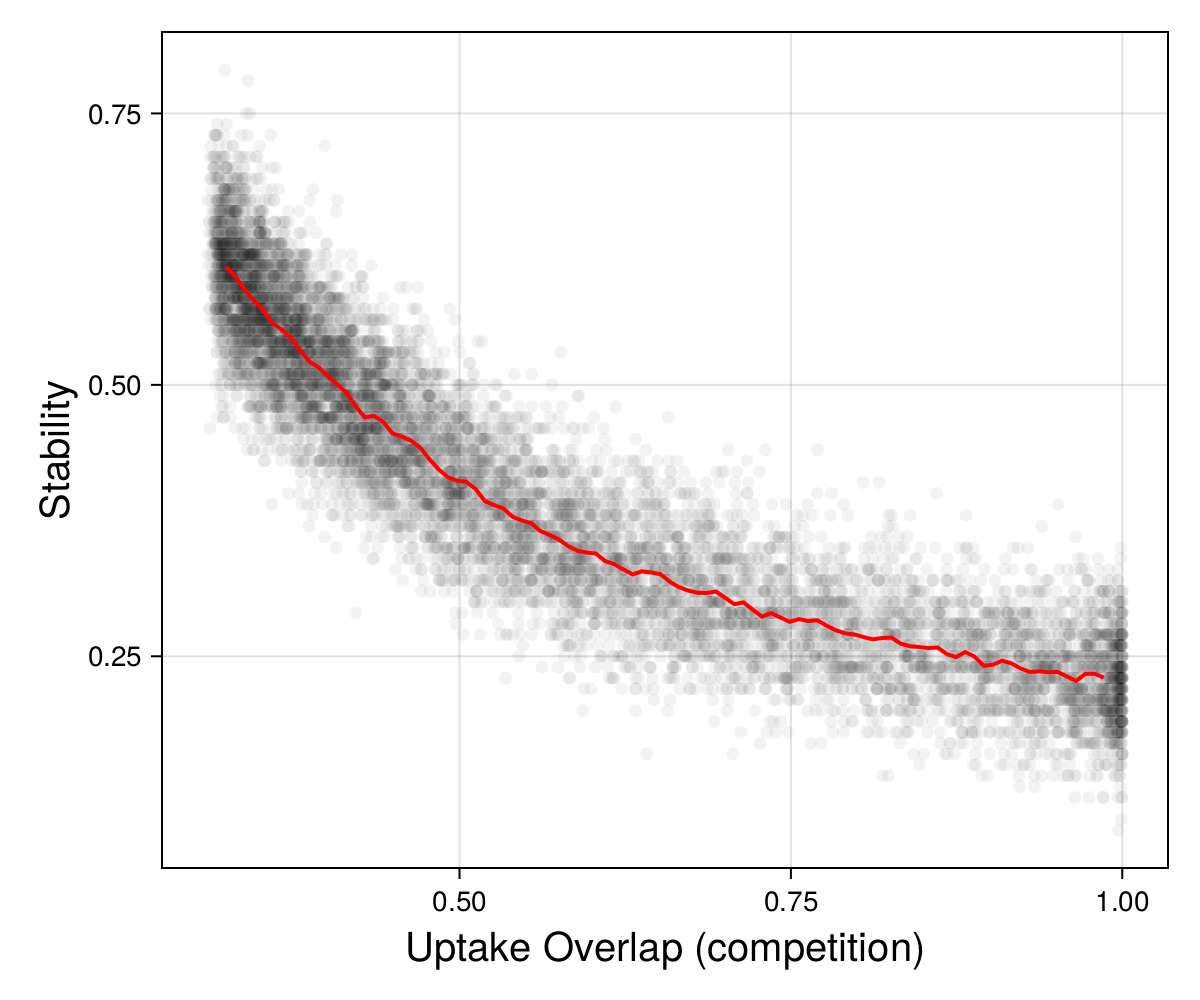

In [235]:
f = Figure(size = (600,500))
ax = Axis(f[1,1], xlabel = "Uptake Overlap (competition)", ylabel = "Stability", xlabelsize = 20, ylabelsize = 20)

plot!(ax,o_mat, mean(λ_mat .< 0, dims = 2)[:], color = (:black, 0.05))
lines!(ax, mean_UU, mean_λ, color = "red", linewidth = 2)
f

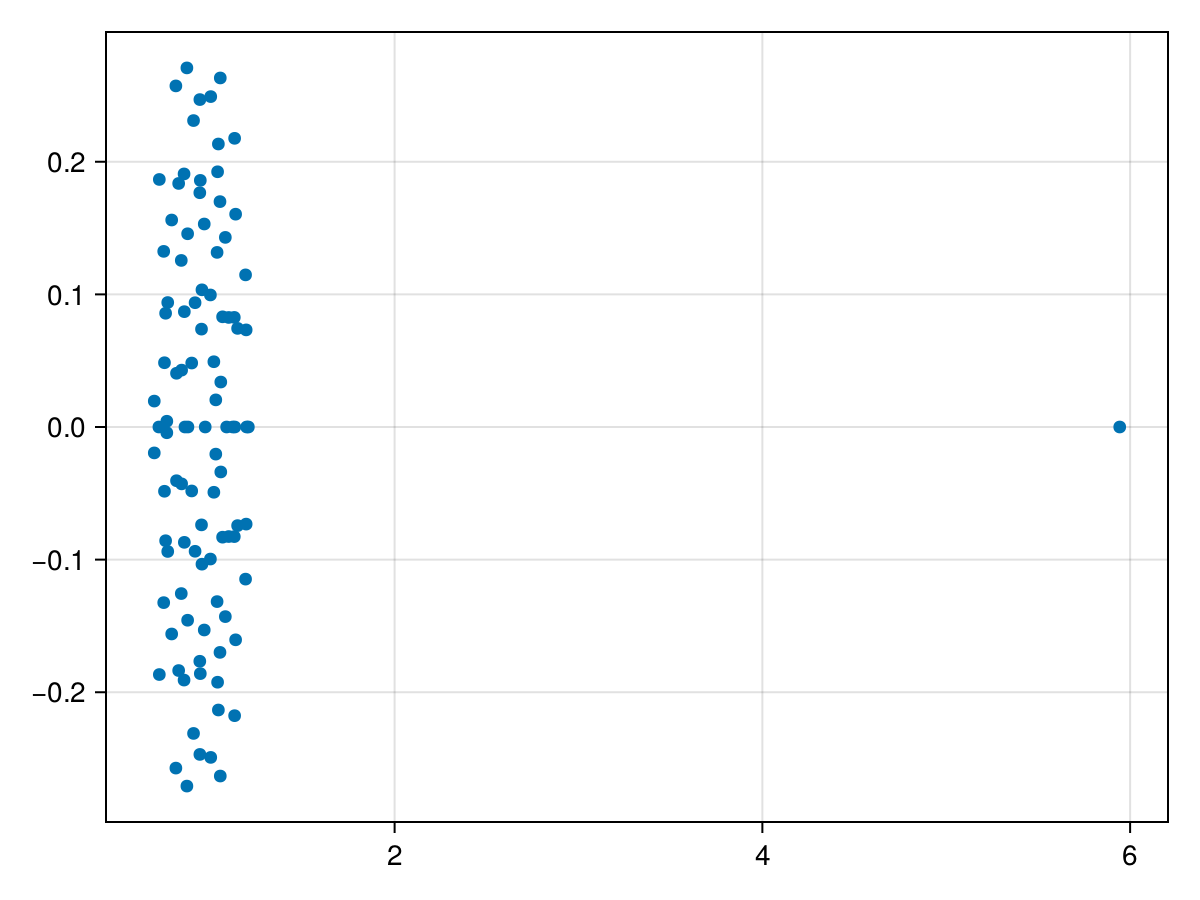

In [310]:

J = 0.1rand(100,100) 
J[diagind(J)] .= 1
λ = eigen(J)

re_vec = [x.re for x = λ.values]
im_vec = [x.im for x = λ.values]

plot(re_vec, im_vec)

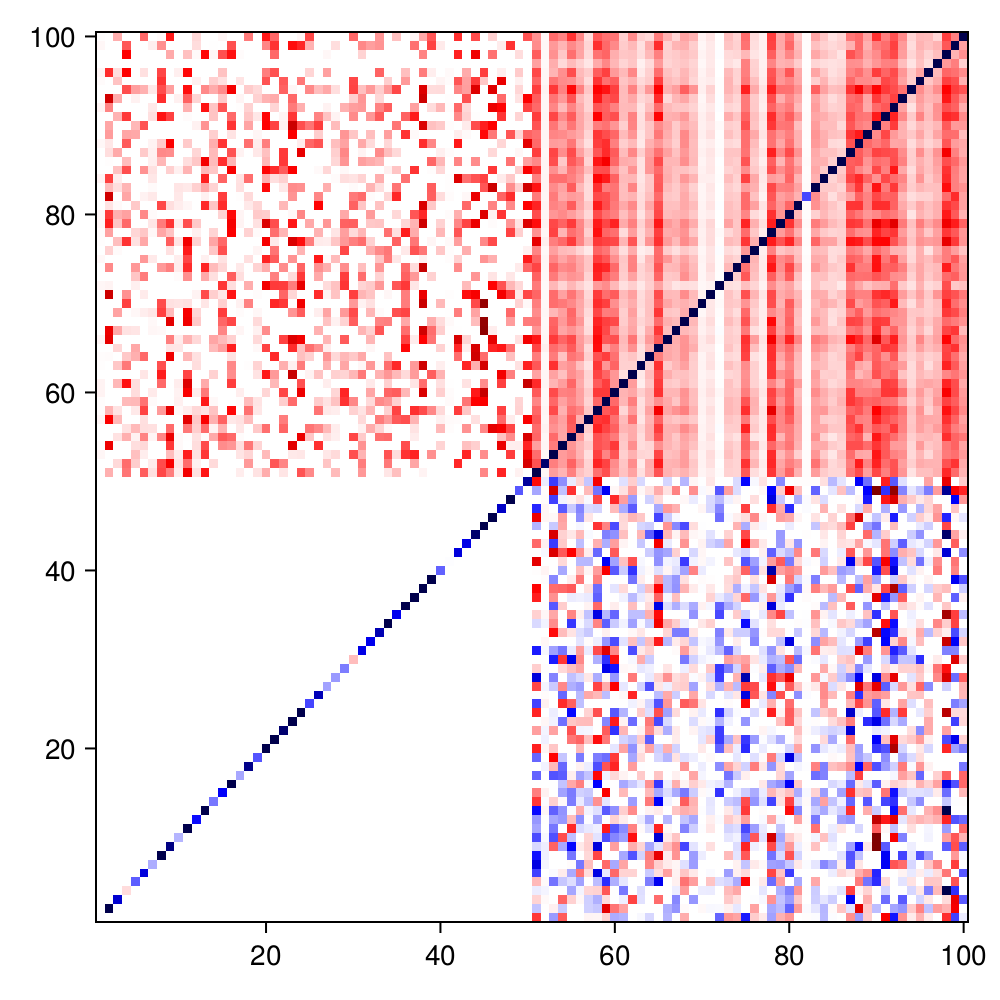

In [294]:
v = abs.(J[:]) |> maximum
v = v - v + 0.1

f = Figure(size = (500,500))
ax = Axis(f[1,1])
heatmap!(ax, J, colormap = :seismic, colorrange = (-v,v))
f

In [ ]:
UU_mat

In [428]:
i = 6
(UU_bins[i-1] .< UU_mat[ind] .<= UU_bins[i+1]) |

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///home/tom/Projects/MiCRM_stability/Notebooks/In[428]#2:49\[90mIn[428]:2:49[0;0m]8;;\
i = 6
(UU_bins[i-1] .< UU_mat[ind] .<= UU_bins[i+1]) |[48;2;120;70;70m[0;0m
[90m#                                               └ ── [0;0m[91mpremature end of input[0;0m

In [133]:
save("../Results/Figures/Interactions.png", f)

CairoMakie.Screen{IMAGE}


## Random vs niche model
How important is the structure created by the niche model?

In [49]:
function get_exponential_parameters(N,M)
    σ = 0.1
    gx = 0.95 .* ones(N) .+ rand(Uniform(-σ,σ), N)
    gs = ones(N) .+ rand(Uniform(-σ,σ), N)
    gw = zeros(N) #-ones(N) .+ rand(Uniform(-σ,σ), N)
    mx = ones(N) .+ rand(Uniform(-σ,σ), N)
    
    fy = ones(N,M)
    hy = -ones(N,M)
    
    λy = zeros(N,M)
    ωy = zeros(N,M)

    iy = zeros(M)
    oy = ones(M) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

get_exponential_parameters (generic function with 1 method)

In [85]:
N = 25
M = 100
C = 0.2
Ncom = 100
Nrep = 100
Nshuffle = 2

J = zeros(N+M,N+M)

λ_mat = zeros(Ncom, Nshuffle, Nrep)
c_mat = Array{MiCRM_stability.Community, 2}(undef, Ncom, Nshuffle)
c = 0
k = [0]

Threads.@threads for i = 1:Ncom
    k[1] += 1
    print("\r", k)
    
    #generate communites - assert it is connected
    begin
        f = true
        c = 0
        
        while f
            c = rand_com(N,M,C)
            f = !check_connected(c)
        end
        
        # c.U .= c.U .* rand(N,M)
        # c.L .= c.L .* rand(N,M)
    end

    for j = 1:Nshuffle
        # #get struct
        c_mat[i,j] = deepcopy(c)
        
        #shuffle
        c_vec = Vector{MiCRM_stability.Community}(undef, 1001)
        c_vec[1] = deepcopy(c)
        for s = 2:1000
            dis_con = true
            while dis_con
                shuffle!(c)
                if check_connected(c)
                        dis_con = false
                else
                    c = deepcopy(c_vec[s-1])
                end
            end
            c_vec[s] = deepcopy(c)
        end
    end
end

# print(mean(λ_mat .< 0, dims = 3)[:,:,1])

[100]

In [51]:
#calculate stabiltiy
function calc_stab(c, Nrep)
    λ = zeros(Complex, Nrep)
    sp = MiCRM_stability.get_structural_params(c.U, c.L, c.N, c.M) 
    J = zeros(c.N + c.M, c.N + c.M)
    for k = 1:Nrep
        #get params and stabiltiy
        ep = get_exponential_parameters(c.N, c.M)
        p = MiCRM_stability.Parameters(c.N,c.M,sp, ep) 
        MiCRM_stability.jacobian!(p, J)
        λ[k] = eigsolve(J, 1, (:LR))[1][1]
    end

    return(λ)
end



calc_stab (generic function with 1 method)

In [52]:
#calculate stabiltiy
λ = zeros(Ncom, Nshuffle)
λ2 = zeros(Ncom, Nshuffle)

k = [0]
Threads.@threads for i = 1:Ncom
    k[1] += 1
    for j = 1:Nshuffle
        print(k, "\r")
        λ[i,j] = mean(get_real.(calc_stab(c_mat[i,j], Nrep)).< 0)
    end
end

In [138]:
res = load("../Results/data/niche_stabiltiy.jld2")

λ = res["l"]
Ncom, _ = size(λ)
# λ = mean(λ_mat .< 0, dims = 3)[:,:,1]



(1000, 2)

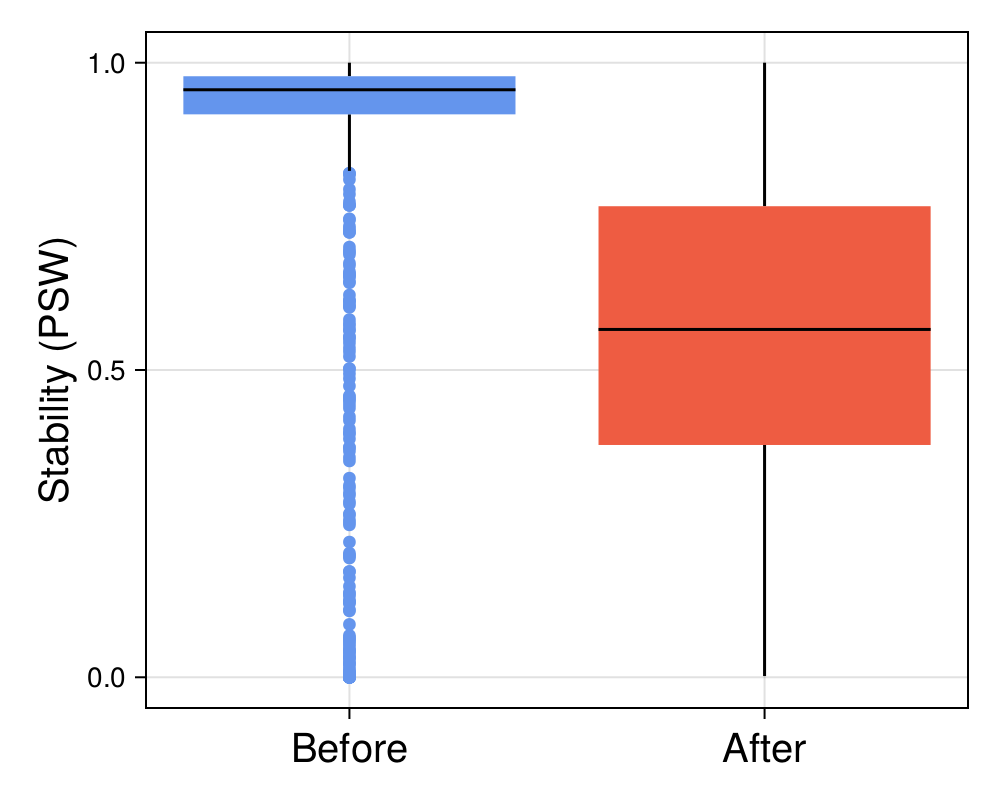

In [139]:
f = Figure(size = (500,400))
ax = Axis(f[1:3,1], xticks = (0:1, ["Before","After"]), ylabel = "Stability (PSW)", xticklabelsize = 20, ylabelsize = 20)

# ylims!(ax, 0,1)

boxplot!(ax, zeros(Ncom), λ[:,1], color = :cornflowerblue)
boxplot!(ax, ones(Ncom), λ[:,end], color = :tomato2)

f

In [140]:
save("../Results/Figures/Shuffle_webs.png", f)

CairoMakie.Screen{IMAGE}


# Modularity + Nestedness

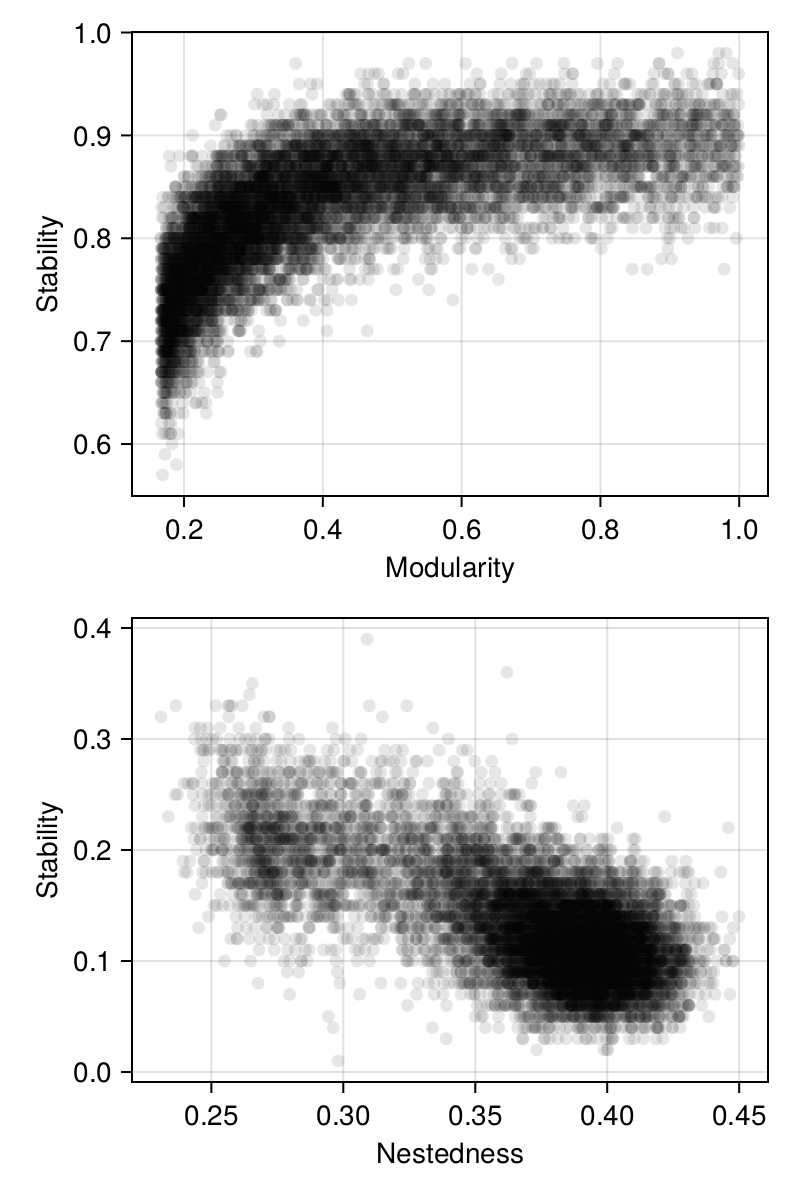

In [28]:
res = load("../Results/data/modularity_stabiltiy.jld2")

λ_mat = res["l"]
c_mat = res["c"]

c_ratio = c_mat[:,1] ./ c_mat[:,2]
stab = mean(λ_mat .< 0, dims = 2)[:]

#binning approach
Nbins = 25
c_bins = range(minimum(c_ratio), maximum(c_ratio), length = Nbins)
mean_stab = [ stab[c_bins[i-1] .< c_ratio .< c_bins[i+1]] |> mean for i = 2:(Nbins-1)]
mean_c = [(c_bins[i-1] + c_bins[i+1]) / 2 for i = 2:(Nbins-1)];

f = Figure(size = (400,600))
ax = Axis(f[1,1], xlabel = "Modularity", ylabel = "Stability")
plot!(ax, c_ratio, stab, color = (:black, 0.1))
# lines!(ax, mean_c, mean_stab, color = (:red))

res = load("../Results/data/nestedness_stabiltiy.jld2")

λ_mat = res["l"]
n_mat = res["n"]

stab = mean(λ_mat .< 0, dims = 2)[:]

#binning approach
Nbins = 10
n_bins = range(minimum(n_mat), maximum(n_mat), length = Nbins)
mean_stab = [ stab[n_bins[i-1] .< n_mat .< n_bins[i+1]] |> mean for i = 2:(Nbins-1)]
mean_n = [(n_bins[i-1] + n_bins[i+1]) / 2 for i = 2:(Nbins-1)];

ax = Axis(f[2,1], ylabel = "Stability", xlabel = "Nestedness")
plot!(ax, n_mat, stab, color = (:black, 0.1))
# lines!(ax, mean_n, mean_stab, color = (:red))


f

In [633]:
function nodf(A)
    N,M = size(A)
    #rows
    #get ones
    row_ind = [findall(A[i,:] .> 0) for i = 1:N]
    overlap(x,y) = sum(y) != 0 ? sum(minimum.(zip(x,y))) / sum(y) : 0
    x_row = [[length(row_ind[i]) > length(row_ind[j]) ? overlap(A[i,:], A[j,:]) : 0 for j = i+1:N] for i = 1:N] 
    
    col_ind = [findall(A[:,i] .> 0) for i = 1:M]
    x_col = [[length(col_ind[i]) > length(col_ind[j]) ? overlap(A[:,i], A[:,j]) : 0 for j = i+1:M] for i = 1:M] 
    
    return mean(vcat(x_row..., x_col...))
end

nodf (generic function with 1 method)

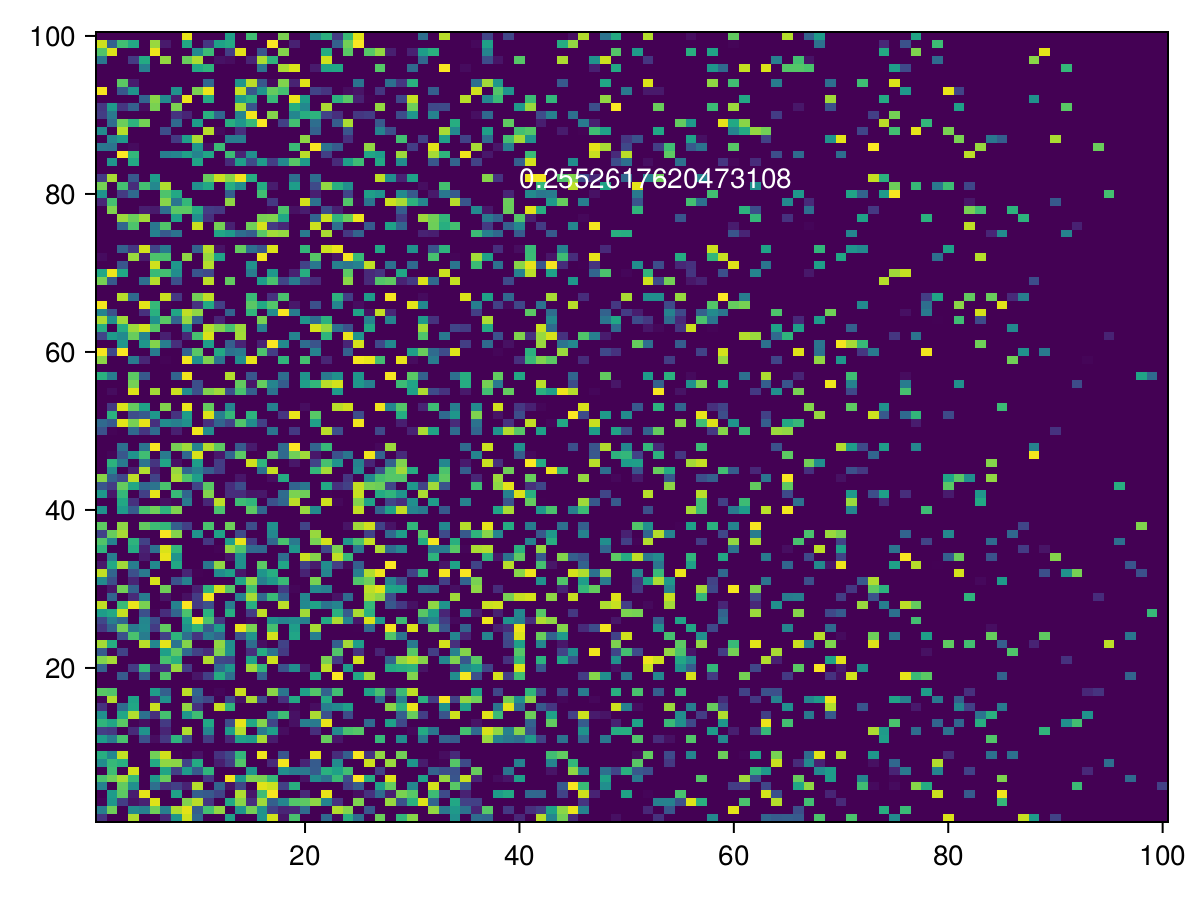

In [721]:
N,M = 100,100
c = MiCRM_stability.nested_community(N,M, -0.25, 0, 10, 10)

A = c.U

f = Figure()
ax = Axis(f[1,1])
heatmap!(ax, A)
n = nodf(A)
text!(ax, 40,80, text = "$n", color = "white")
f


# Invasions

In [264]:
res = load("../Results/data/.jld2")

# λ_mat = res["l"]
# c_mat = res["c"]

# c_ratio = c_mat[:,1] ./ c_mat[:,2]
# stab = mean(λ_mat .< 0, dims = 2)[:]

Dict{String, Any} with 2 entries:
  "I" => [0.664521, -0.0852237, -0.804296, 0.347727, -0.94477, 0.977243, -0.048…
  "l" => [0.0108533 0.00216881 … 0.0108132 -0.000245827; 0.0139862 0.0143259 … …

In [262]:
fspec(N,M,C) = MiCRM_stability.specialist_community(N, M, 0.1, 0.5, Int(floor(M * C)), Int(floor(M * C)))

function add_consumer(com, I)
    #calculate exploitation
    κU, κL = -I * 10.0, I * 10.0
    exp_vec = sum(com.U,dims=1)[:]
    exp_vec = exp_vec ./ maximum(exp_vec)
    pU = [p > 0 ? p^κU : 0 for p = exp_vec]
    
    U_new = fill(0.01, N+1, M)
    U_new[1:N,:] .= com.U
    
    k = rand(Binomial(M, 0.1))
    U_new[end, sample(collect(1:M), Weights(pU), k, replace = false)] .+= 0.5
    
    #calculate leakage
    # leak_vec = sum(com.L, dims = 1)[:]
    # leak_vec = leak_vec ./ maximum(leak_vec)
    pL = [p > 0 ? p^κL : 0 for p = exp_vec]
    
    L_new = fill(0.01, N+1, M)
    L_new[1:N,:] .= com.L
    
    k = rand(Binomial(M, 0.1))
    L_new[end, sample(collect(1:M), Weights(pL), k , replace = false)] .+= 0.5
    
    new_com = MiCRM_stability.Community(N+1, M, U_new, L_new)
end

add_consumer (generic function with 2 methods)

In [263]:
com = fspec(N,M,C)

MiCRM_stability.get_structural_params(add_consumer(com,0.0))

MiCRM_stability.structural_params([0.21391187138708356, 0.3248891073139747, 0.2531286397628628, 0.9936090163900114, 0.0029928091666705514, 0.4425809833672891, 0.40099845309811566, 0.272420903886891, 0.001044616643795293, 0.08833832680314146  …  0.7380600197701156, 0.1406272236305548, 0.10171734154520351, 0.31436008514022395, 0.5871621848683098, 0.19844896287626823, 0.9098232899502515, 0.46310383742516914, 0.23146236288342015, 0.7697112169317692], [0.0881972874545548, 0.4826633602796777, 0.7781137546193365, 0.82442904566569, 0.9703183407642351, 0.5134222476054938, 0.34515697967933967, 0.3875846974564343, 0.9645486444263369, 0.6463532886949599  …  0.22565872063917858, 0.2709831630301901, 0.7906033301244432, 0.3285183675816479, 0.2988424673423269, 0.3844789960290622, 0.38915287626448314, 0.7004271277099142, 0.664044682424261, 0.0952678934200083], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [255]:
N,M,C = 100,100,0.2
com = fspec(N,M,C)

U_inital = get_U_overlap(com)
L_inital = get_L_overlap(com)

Nrep  = 100
U_over_vec = zeros(Nrep,2)
L_over_vec = zeros(Nrep,2)

I = -1

Threads.@threads for i = 1:Nrep
    U_over_vec[i,1] = get_U_overlap(add_consumer(com, )
    L_over_vec[i,1] = get_L_overlap(add_consumer(com, -I * 10.0, I * 10.0))
end

I = 1

Threads.@threads for i = 1:Nrep
    U_over_vec[i,2] = get_U_overlap(add_consumer(com, -I * 10.0, I * 10.0))
    L_over_vec[i,2] = get_L_overlap(add_consumer(com, -I * 10.0, I * 10.0))
end

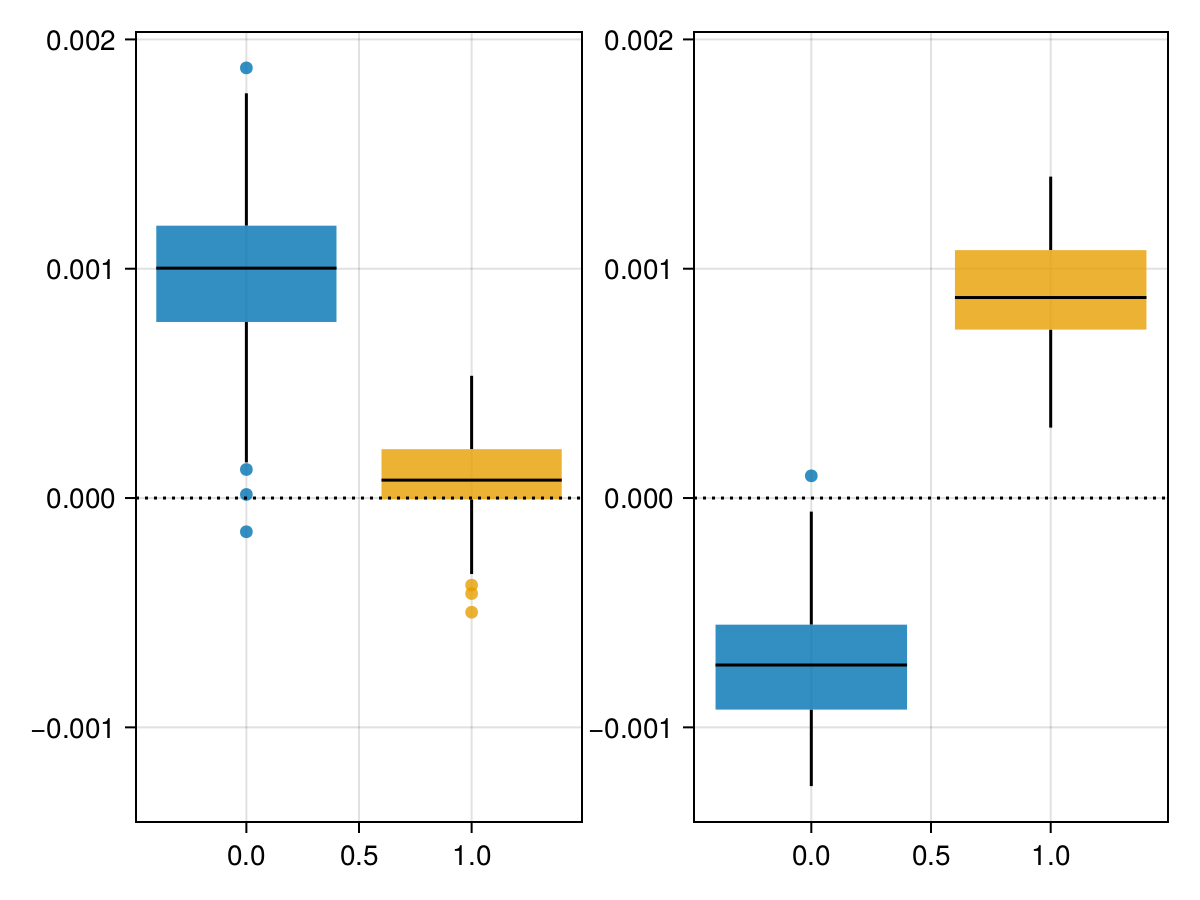

In [256]:
f = Figure()

ax = Axis(f[1,1])
boxplot!(ax, zeros(Nrep), U_over_vec[:,1] .- U_inital)
boxplot!(ax, ones(Nrep), L_over_vec[:,1] .- L_inital)
hlines!(ax, 0, color = :black, linestyle = :dot)

ax = Axis(f[1,2])
boxplot!(ax, zeros(Nrep), U_over_vec[:,2] .- U_inital)
boxplot!(ax, ones(Nrep), L_over_vec[:,2] .- L_inital)
hlines!(ax, 0, color = :black, linestyle = :dot)

linkyaxes!(f.content...)

f

## Empirical Data

In [717]:
#read empirical matricies
C = readdlm("../data/C_mat.csv",',') .> 0
K = readdlm("../data/D_mat.csv",',') .> 0;

┌ Warning: Since there are a lot of edges (578 > 500), they will be drawn as straight lines even though they contain curvy edges. If you really want to plot them as bezier curves pass `edge_plottype=:beziersegments` explicitly. This will have much worse performance!
└ @ GraphMakie ~/.julia/packages/GraphMakie/yyvus/src/recipes.jl:526


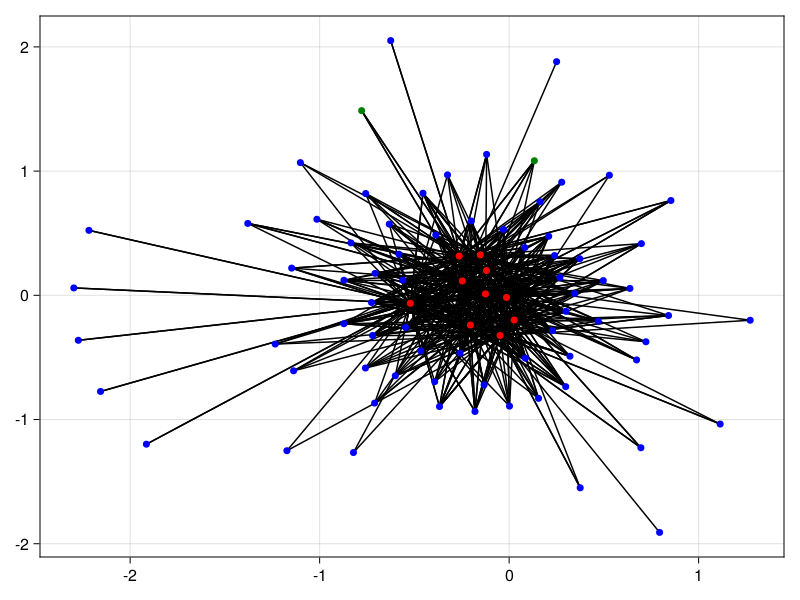

In [781]:
N = size(C)[1]
non_zero = (sum(C, dims = 1)[:] .!= 0) .& (sum(K, dims = 1)[:] .!= 0)

ind = rand(1:N, 10)

U = C[ind,non_zero]
L = K[ind,non_zero]

ind_2 = findall(sum(U, dims = 1)[:] .!= 0)

c = MiCRM_stability.Community(length(ind),length(ind_2), U[:,ind_2], L[:,ind_2])
check_connected(c)


fig = Figure()
ax = Axis(fig[1,1])
plot_com!(c,ax, as = 0.001)
fig